# Import libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

# Load the Dataset

## Upload train_data,test_data & test_data_hidden

In [2]:
train_data = pd.read_csv(r'C:\Users\zubair_khan\Desktop\Data_Science\Projects\Capstone-Project-2-digi-chrome\data\cleaned_train_data.csv')
test_data = pd.read_csv(r'C:\Users\zubair_khan\Desktop\Data_Science\Projects\Capstone-Project-2-digi-chrome\data\cleaned_test_data.csv')
test_data_hidden = pd.read_csv(r'C:\Users\zubair_khan\Desktop\Data_Science\Projects\Capstone-Project-2-digi-chrome\data\cleaned_test_data_hidden.csv')

In [3]:
train_data.shape , test_data.shape , test_data_hidden.shape

((3990, 8), (997, 7), (997, 8))

In [4]:
train_data.columns , test_data.columns , test_data_hidden.columns

(Index(['Name of the product', 'Product Brand', 'categories',
        'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
        'sentiment'],
       dtype='object'),
 Index(['Name of the product', 'Product Brand', 'categories',
        'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title'],
       dtype='object'),
 Index(['Name of the product', 'Product Brand', 'categories',
        'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
        'sentiment'],
       dtype='object'))

In [6]:
train_data.duplicated() , test_data.duplicated() , test_data_hidden.duplicated()

(0       False
 1       False
 2       False
 3       False
 4       False
         ...  
 3985    False
 3986    False
 3987    False
 3988    False
 3989    False
 Length: 3990, dtype: bool,
 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 992    False
 993    False
 994    False
 995    False
 996    False
 Length: 997, dtype: bool,
 0      False
 1      False
 2      False
 3      False
 4      False
        ...  
 992    False
 993    False
 994    False
 995    False
 996    False
 Length: 997, dtype: bool)

## task-1.1- Exploratory Data Analysis (EDA):

### 1. Check Sentiment Distribution

In [7]:
# Check distribution of sentiments
sentiment_counts = train_data['sentiment'].value_counts()
sentiment_counts

sentiment
Positive    3739
Neutral      158
Negative      93
Name: count, dtype: int64

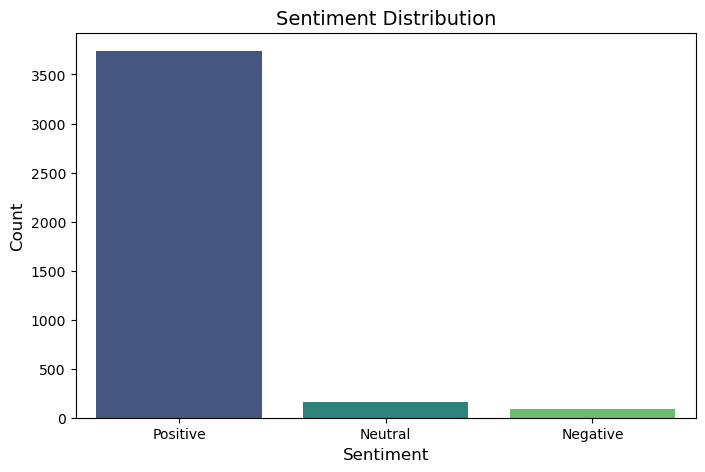

In [8]:
# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='sentiment', palette='viridis', order=sentiment_counts.index)
plt.title('Sentiment Distribution', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### 2. Address Class Imbalance

In [9]:
# Calculate proportions of each sentiment class
sentiment_proportions = sentiment_counts / len(train_data)
sentiment_proportions

sentiment
Positive    0.937093
Neutral     0.039599
Negative    0.023308
Name: count, dtype: float64

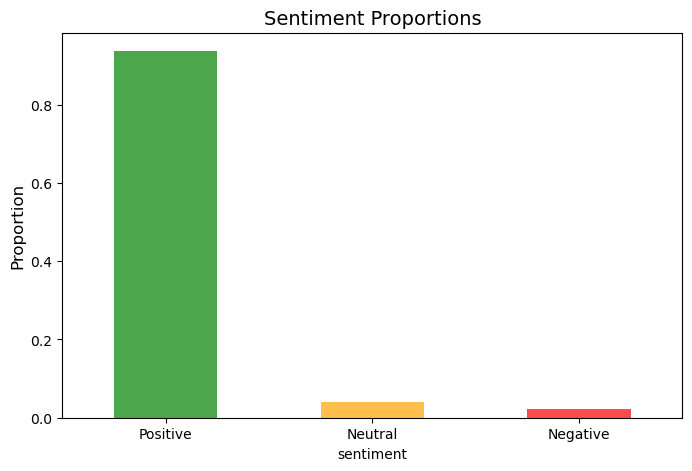

In [10]:
# Visualize class proportions
plt.figure(figsize=(8, 5))
sentiment_proportions.plot(kind='bar', color=['green', 'orange', 'red'], alpha=0.7)
plt.title('Sentiment Proportions', fontsize=14)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.show()

### 3. Analyze Trends and Patterns in Reviews

In [11]:
# Review Length Analysis
# Calculate review text length
train_data['review_length'] = train_data['reviews.text'].apply(lambda x: len(str(x))) 

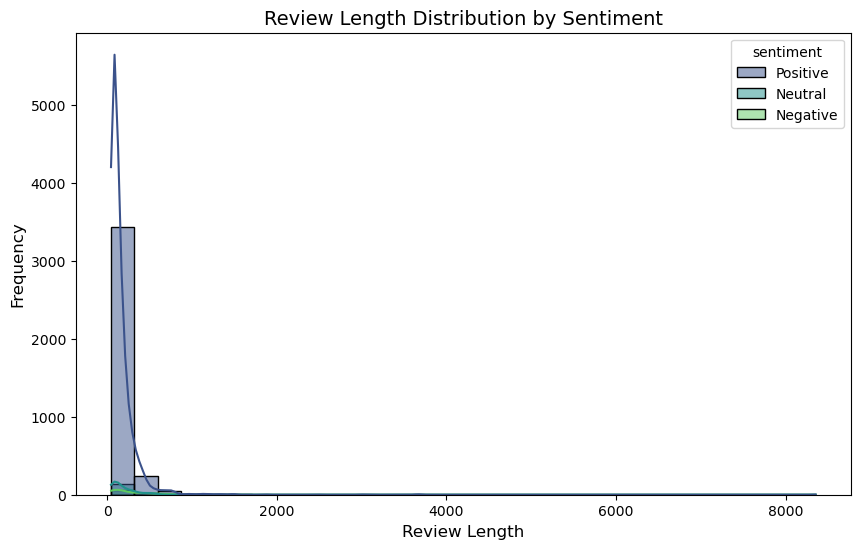

In [12]:
# Visualize distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='review_length', hue='sentiment', kde=True, palette='viridis', bins=30)
plt.title('Review Length Distribution by Sentiment', fontsize=14)
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [13]:
#  Analyze Sentiment over Time
# Convert review date to datetime
train_data['reviews.date'] = pd.to_datetime(train_data['reviews.date'], errors='coerce')

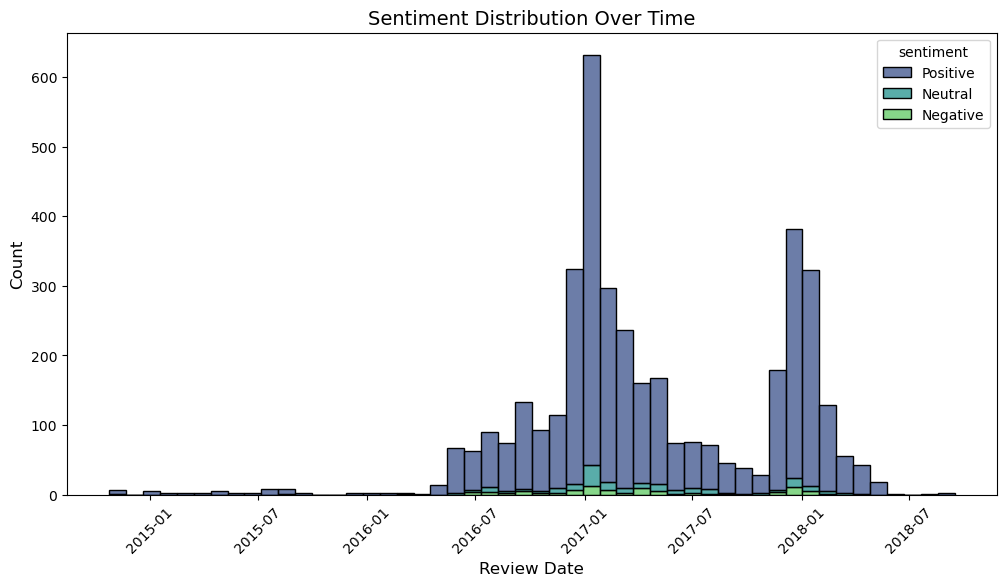

In [14]:
# Plot sentiment counts over time
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='reviews.date', hue='sentiment', multiple='stack', palette='viridis', bins=50)
plt.title('Sentiment Distribution Over Time', fontsize=14)
plt.xlabel('Review Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 4. Visualize Category and Brand Trends

In [15]:
# Sentiments by Product Brand
# Top 10 brands by sentiment
top_brands = train_data['Product Brand'].value_counts().head(10).index
top_brands

Index(['Amazon'], dtype='object', name='Product Brand')

In [16]:
brand_sentiments = train_data[train_data['Product Brand'].isin(top_brands)]
brand_sentiments

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26 00:00:00+00:00,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,409
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17 00:00:00+00:00,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,593
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20 00:00:00+00:00,Just an average Alexa option. Does show a few ...,Average,Neutral,81
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04 00:00:00+00:00,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,63
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23 00:00:00+00:00,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,179
...,...,...,...,...,...,...,...,...,...
3985,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2017-12-08 00:00:00+00:00,"It‚Äôs fun for the family to play with, but it...",Fun toy,Positive,103
3986,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,2017-03-31 00:00:00+00:00,"I love the Kindle, it is a great product. It r...",Great Product,Positive,115
3987,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,Amazon,"Amazon Echo,Home Theater & Audio,MP3 MP4 Playe...",Electronics,2017-01-19 00:00:00+00:00,I was looking for a blutooth speaker to use wi...,"Great ""dumb"" speaker",Positive,648
3988,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-05-27 00:00:00+00:00,This is the second Amazon Fire 7 tablet I have...,A great 7 inch tablet at a great price,Positive,147


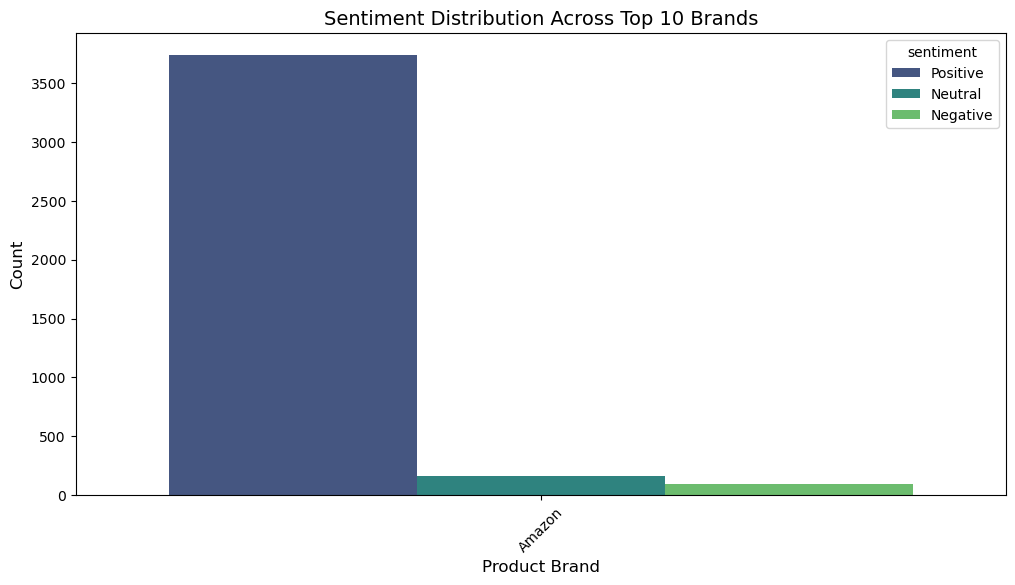

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=brand_sentiments, x='Product Brand', hue='sentiment', palette='viridis', order=top_brands)
plt.title('Sentiment Distribution Across Top 10 Brands', fontsize=14)
plt.xlabel('Product Brand', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [18]:
# Sentiments by Categoriesabs
# Top 10 categories by sentiment
top_categories = train_data['categories'].value_counts().head(10).index
top_categories

Index(['Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets',
       'Computers,Amazon Echo,Virtual Assistant Speakers,Audio & Video Components,Electronics Features,Computer Accessories,Home & Tools,See more Amazon Echo Show Smart Assistant - White,Smart Home Automation,Electronics,TVs Entertainment,Speakers,Smart Hub & Kits,Digital Device 3,Consumer Electronics,Wireless Speakers,Home Improvement,Amazon Home,Amazon,Computer Speakers,Voice-Enabled Smart Assistants',
       'Amazon Echo,Smart Home,Networking,Home & Tools,Home Improvement,Smart Home Automation,Voice Assistants,Amazon Home,Amazon,Smart Hub & Kits,Digital Device 3',
       'Computers,Fire Tablets,Electronics Features,Computer Accessories,Tablets,Top Rated,Amazon Tablets,Electronics,Kids' Tablets,iPad & Tablets,Cases & Bags,Electronics, Tech Toys, Movies, Music,Computers & Tablets',
       'Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,Tablets,All Tablets',
       'Fir

In [19]:
category_sentiments = train_data[train_data['categories'].isin(top_categories)]
category_sentiments

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26 00:00:00+00:00,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,409
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17 00:00:00+00:00,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,593
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20 00:00:00+00:00,Just an average Alexa option. Does show a few ...,Average,Neutral,81
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23 00:00:00+00:00,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,179
5,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-12-23 00:00:00+00:00,This is a great product. Light weight. I wish ...,You will love it,Positive,82
...,...,...,...,...,...,...,...,...,...
3984,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-27 00:00:00+00:00,"It is great , I like it very much. I can find ...",great responding,Positive,64
3985,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2017-12-08 00:00:00+00:00,"It‚Äôs fun for the family to play with, but it...",Fun toy,Positive,103
3987,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,Amazon,"Amazon Echo,Home Theater & Audio,MP3 MP4 Playe...",Electronics,2017-01-19 00:00:00+00:00,I was looking for a blutooth speaker to use wi...,"Great ""dumb"" speaker",Positive,648
3988,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-05-27 00:00:00+00:00,This is the second Amazon Fire 7 tablet I have...,A great 7 inch tablet at a great price,Positive,147


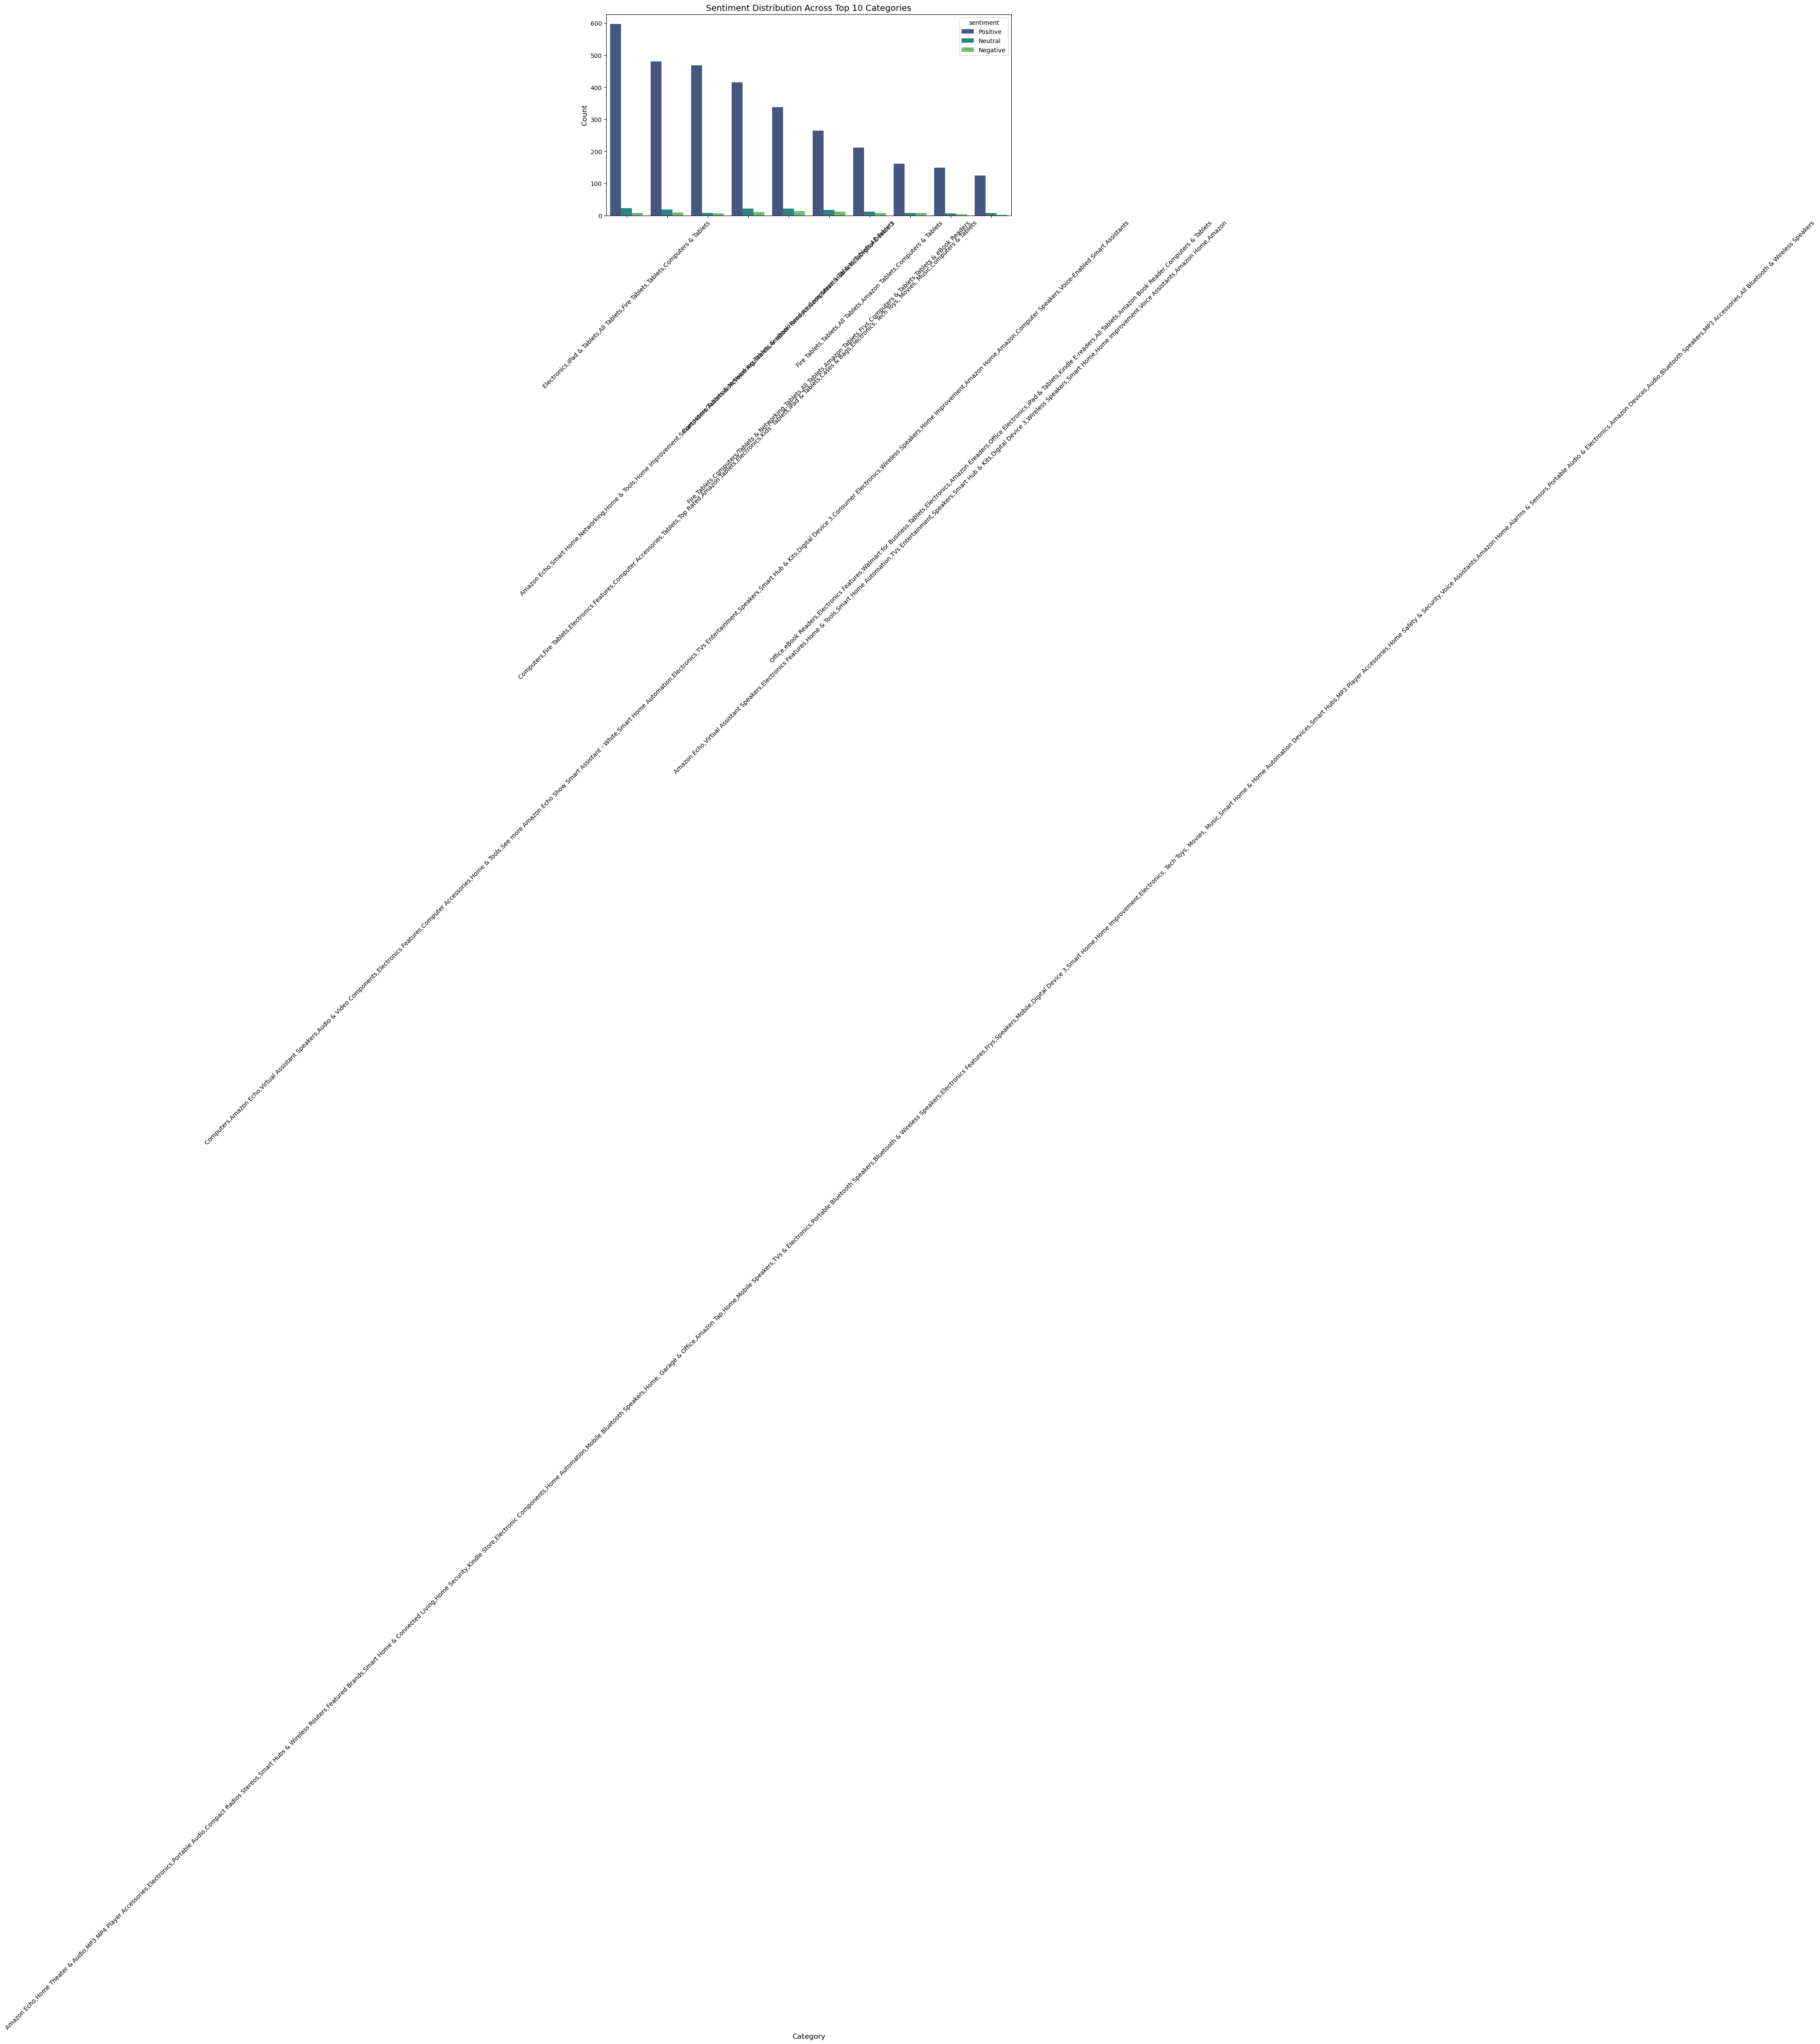

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(data=category_sentiments, x='categories', hue='sentiment', palette='viridis', order=top_categories)
plt.title('Sentiment Distribution Across Top 10 Categories', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## Insights to Derive
### 1. Sentiment Distribution:

Check if the dataset is balanced or skewed toward specific sentiments.
Identify if data augmentation techniques are required to balance classes.
    
### 2. Review Length Trends:

Analyze if review length is associated with sentiment (e.g., longer reviews for negative sentiments).
                                                       
### 3. Time-based Trends:

Detect seasonal trends or spikes in sentiments over time.
    
### 3. Brand and Category Insights:

Determine which brands/categories receive predominantly positive or negative reviews.

## task-1.2-  Feature Engineering:

### 1. TF-IDF Transformation

In [22]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  
    stop_words='english', 
    ngram_range=(1, 2) 
)

In [23]:
# Fit and transform the review text
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['reviews.text'])

In [24]:
tfidf_matrix.shape

(3990, 5000)

In [25]:
# Convert the TF-IDF matrix to a DataFrame for easier analysis
tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_features.head()

,00,10,10 year,100,11,11 2016,11yr,11yr old,12,12 year,...,äôs fun,äôs great,äôs news,äôt,äôt know,äôt use,äôt wait,äôve,äù,äúalexa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Add TF-IDF Features Back to the Dataset

In [26]:
train_data_tfidf = pd.concat([train_data.reset_index(drop=True), tfidf_features], axis=1)
train_data_tfidf.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_length,00,...,äôs fun,äôs great,äôs news,äôt,äôt know,äôt use,äôt wait,äôve,äù,äúalexa
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26 00:00:00+00:00,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,409,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17 00:00:00+00:00,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,593,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20 00:00:00+00:00,Just an average Alexa option. Does show a few ...,Average,Neutral,81,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04 00:00:00+00:00,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,63,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23 00:00:00+00:00,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,179,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
train_data_tfidf.to_csv(r'C:\Users\zubair_khan\Desktop\Data_Science\Projects\Capstone-Project-2-digi-chrome\data\train_data_tfidf.csv', index=False)

### 3. Save Processed Data

## Key Notes:
### 1. TF-IDF Configuration:

max_features=5000: Limits the feature space to 5000 most important terms.
stop_words='english': Removes common English words that are not informative.
ngram_range=(1, 2): Considers both unigrams and bigrams for better context representation.

### 2. Resulting Dataset:

Each row corresponds to a review.
Each column in the tfidf_features DataFrame represents a specific term from the corpus with its corresponding TF-IDF score.
### 3. Handling Large Text Data:

TF-IDF matrices can grow quickly in size, especially with bigram or trigram configurations. Adjust max_features based on memory constraints.

## Task- 1,3 - Classifier Selection:

### 1. Prepare Data

In [29]:
X = tfidf_matrix 
y = train_data['sentiment']

In [30]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train.shape , X_test.shape

((3192, 5000), (798, 5000))

### 2. Address Class Imbalance

In [32]:
# Apply SMOTE to oversample minority classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [33]:
X_train_resampled.shape , y_train_resampled.shape

((8955, 5000), (8955,))

In [34]:
y_train_resampled.value_counts()

sentiment
Positive    2985
Neutral     2985
Negative    2985
Name: count, dtype: int64

### 3. Train Multinomial Naive Bayes Classifier

In [35]:
# Initialize and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [36]:
# Make predictions on the test set
y_pred = nb_model.predict(X_test)

In [37]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n    Negative       0.14      0.40      0.21        10\n     Neutral       0.22      0.53      0.31        34\n    Positive       0.98      0.89      0.93       754\n\n    accuracy                           0.87       798\n   macro avg       0.45      0.61      0.48       798\nweighted avg       0.94      0.87      0.90       798\n'

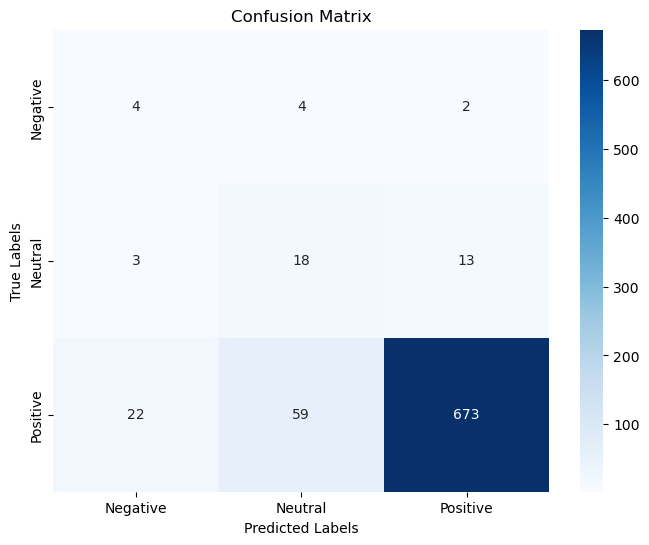

In [38]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [39]:
# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.87


## Key Considerations:
### 1. Class Imbalance:

Using SMOTE ensures that minority classes (e.g., Neutral or Negative) are sufficiently represented during training.
Model Efficiency:

Multinomial Naive Bayes is computationally efficient and performs well on text data with TF-IDF features.
### 2. Evaluation Metrics:

Focus on precision, recall, and F1-score for minority classes to assess how well the model handles imbalanced data.

## Task- 1.4 - Tackling Class Imbalance:

### 1. Check Class Distribution

In [41]:
y.value_counts()

sentiment
Positive    3739
Neutral      158
Negative      93
Name: count, dtype: int64

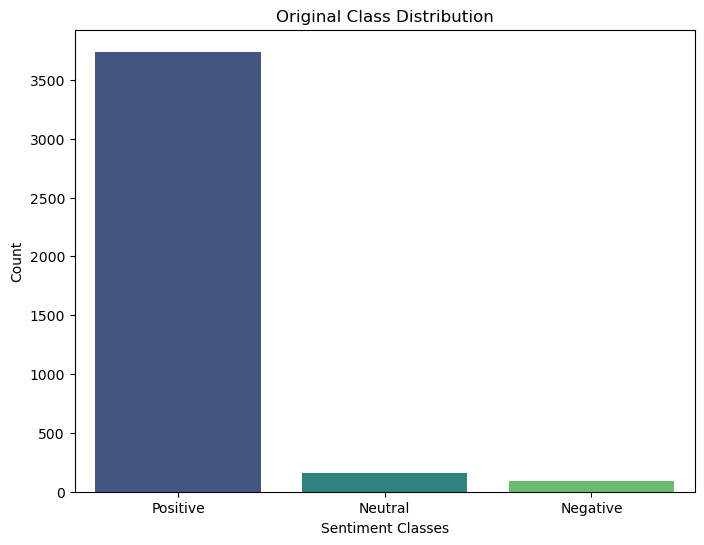

In [42]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette="viridis")
plt.title("Original Class Distribution")
plt.xlabel("Sentiment Classes")
plt.ylabel("Count")
plt.show()

### 2. Oversampling with SMOTE

In [43]:
# Apply SMOTE to oversample minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [44]:
Counter(y_resampled)

Counter({'Positive': 2985, 'Neutral': 2985, 'Negative': 2985})

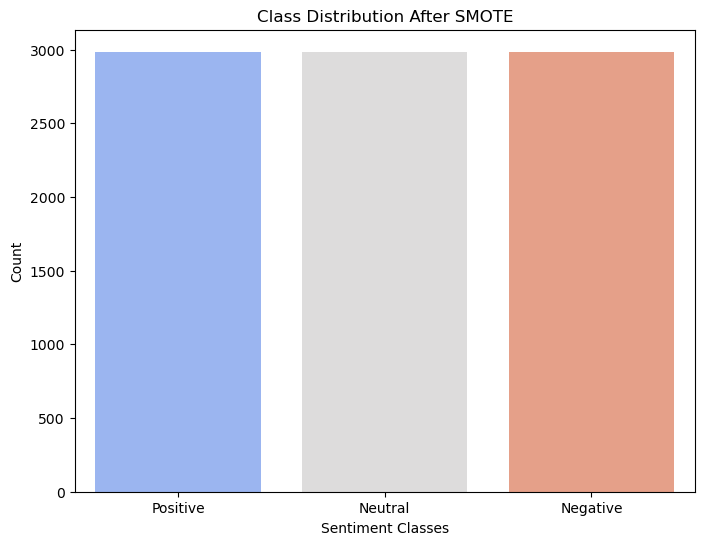

In [45]:
# Visualize the resampled class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette="coolwarm")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Sentiment Classes")
plt.ylabel("Count")
plt.show()

### 3. Under-Sampling the Majority Classabs

In [46]:
# Apply random under-sampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

In [47]:
Counter(y_under)

Counter({'Negative': 83, 'Neutral': 83, 'Positive': 83})

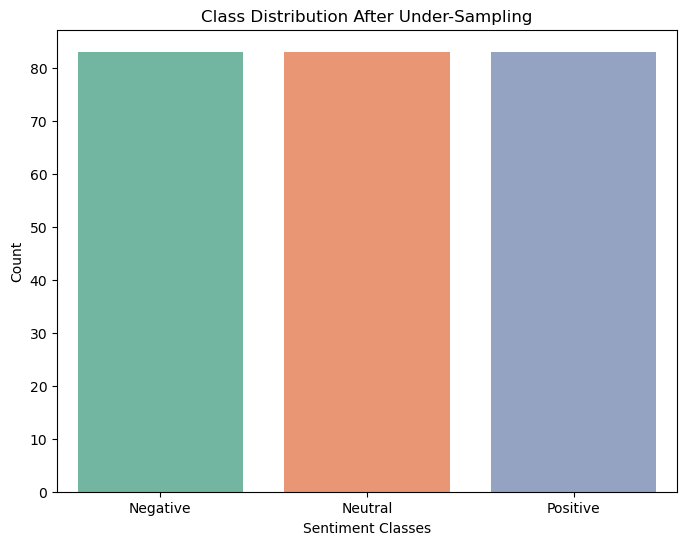

In [48]:
# Visualize the under-sampled class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_under, palette="Set2")
plt.title("Class Distribution After Under-Sampling")
plt.xlabel("Sentiment Classes")
plt.ylabel("Count")
plt.show()

### 4. Combining SMOTE with Under-Sampling (SMOTEENN)

In [50]:
# Apply SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)

In [51]:
Counter(y_smoteenn)

Counter({'Negative': 2985, 'Neutral': 2985, 'Positive': 2910})

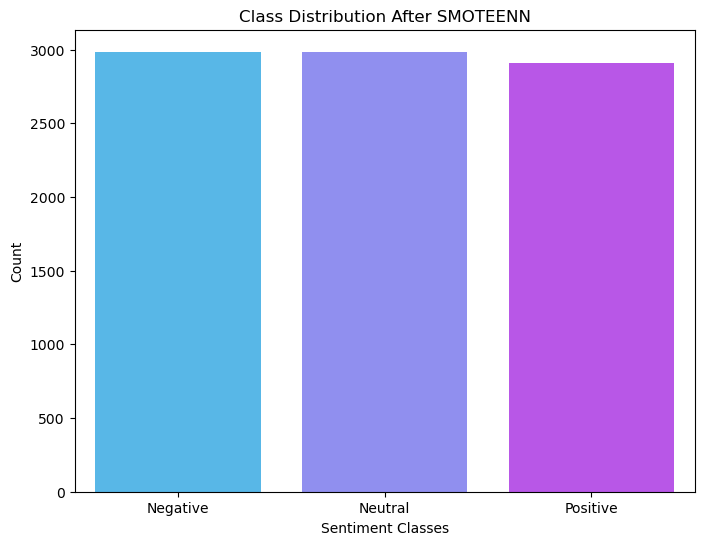

In [52]:
# Visualize the combined resampled class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_smoteenn, palette="cool")
plt.title("Class Distribution After SMOTEENN")
plt.xlabel("Sentiment Classes")
plt.ylabel("Count")
plt.show()

### 5. Train a Model on Resampled Data

In [53]:
# Train a Multinomial Naive Bayes model using the resampled data
nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)

MultinomialNB()

In [54]:
# Predict on the test set
y_pred_resampled = nb_model.predict(X_test)

In [55]:
# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report After Balancing:")
print(classification_report(y_test, y_pred_resampled))

Classification Report After Balancing:
              precision    recall  f1-score   support

    Negative       0.14      0.40      0.21        10
     Neutral       0.22      0.53      0.31        34
    Positive       0.98      0.89      0.93       754

    accuracy                           0.87       798
   macro avg       0.45      0.61      0.48       798
weighted avg       0.94      0.87      0.90       798



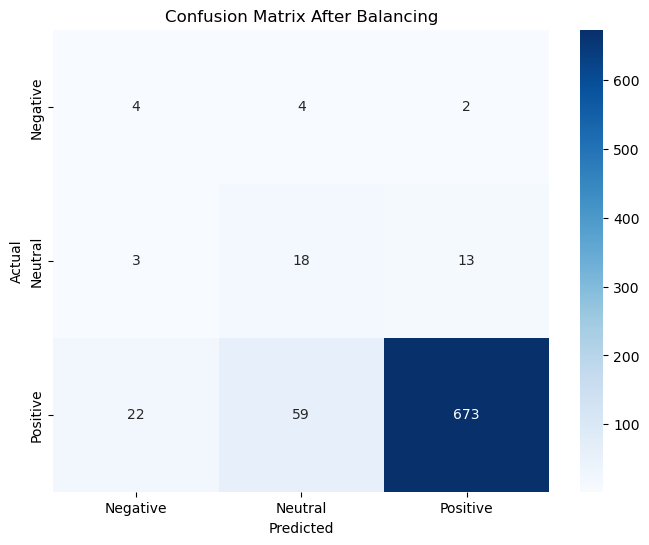

In [56]:
# Confusion Matrix
cm_resampled = confusion_matrix(y_test, y_pred_resampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resampled, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix After Balancing')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Key Considerations:
### 1. Technique Selection:

Use SMOTE for larger datasets with significant class imbalance.
Use Under-Sampling when the dataset is small to avoid memory constraints.
Use SMOTEENN for a hybrid approach that balances and removes noisy samples.
### 2. Evaluation:

Focus on metrics like F1-score and Recall for minority classes to ensure they are correctly predicted.
### 3. Impact on Model:

Balancing the dataset ensures the model does not favor the majority class and performs well across all sentiment categories.

## Task- 1.5 - Evaluation Metrics:

### 1.  Evaluate Precision, Recall, and F1-Score

In [58]:
# Get predictions for the test set
y_pred = nb_model.predict(X_test)  
y_proba = nb_model.predict_proba(X_test)

In [59]:
# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.14      0.40      0.21        10
     Neutral       0.22      0.53      0.31        34
    Positive       0.98      0.89      0.93       754

    accuracy                           0.87       798
   macro avg       0.45      0.61      0.48       798
weighted avg       0.94      0.87      0.90       798



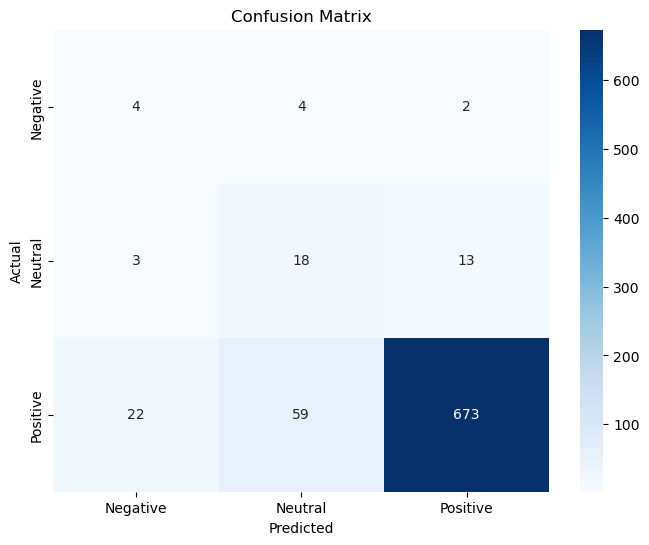

In [60]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 2. Compute AUC-ROC for Multiclass Classification

In [62]:
from sklearn.preprocessing import label_binarize
# Binarize the output labels for multi-class AUC-ROC
y_test_bin = label_binarize(y_test, classes=['Negative', 'Neutral', 'Positive'])
n_classes = y_test_bin.shape[1]

In [63]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

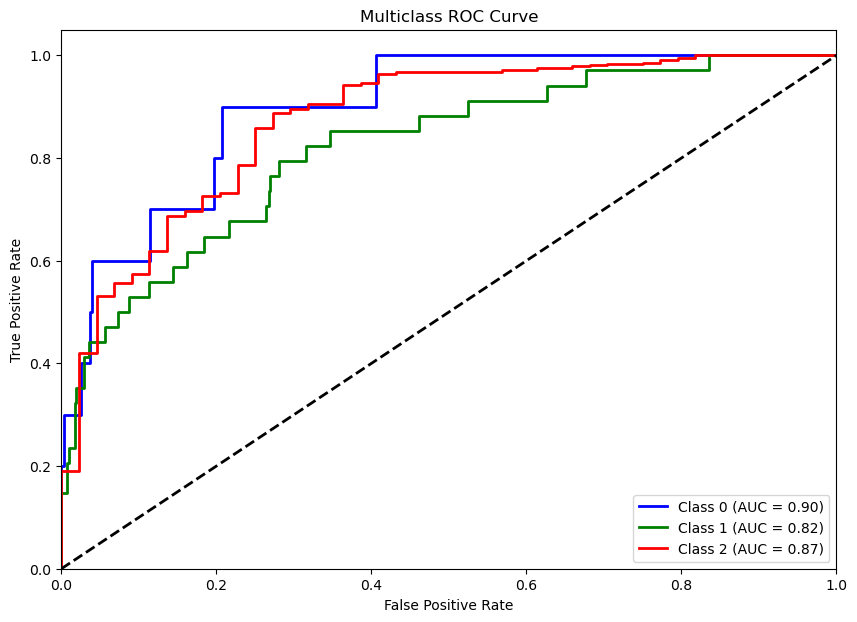

In [64]:
# Plot the ROC curves for each class
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 3. Additional Evaluation Insights

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Macro and weighted metrics
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

In [66]:
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

In [67]:
print(f"Macro Precision: {precision_macro:.2f}, Recall: {recall_macro:.2f}, F1-Score: {f1_macro:.2f}")
print(f"Weighted Precision: {precision_weighted:.2f}, Recall: {recall_weighted:.2f}, F1-Score: {f1_weighted:.2f}")

Macro Precision: 0.45, Recall: 0.61, F1-Score: 0.48
Weighted Precision: 0.94, Recall: 0.87, F1-Score: 0.90


### Evaluation Metrics Summary
Precision: Measures the proportion of true positive predictions among all positive predictions.
Recall: Measures the proportion of true positives identified out of all actual positives.
F1-Score: The harmonic mean of precision and recall, emphasizing the balance between the two.
ROC-AUC: Measures the classifier's ability to distinguish between classes using probability scores.